In [69]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp # for reference

import autograd.numpy as np
from neuralsolver import NNSolver
from sklearn.metrics import mean_squared_error
from math import sqrt

# Problem Definition

In [60]:
def f(t, y):
    # dx/dt = cos(t) + x^2 + y -(1 + t^2 + sin^2(t))
    # dt/dt = 2t - (1 + t^2)sin(t)+xy
    x = y[0]
    y = y[1]
    return [np.cos(t) + x**2 + y - (1 + t**2 + (np.sin(t))**2), 2*t - (1 + t**2)*np.sin(t) + x*y]

t = np.linspace(0, 3, 20).reshape(-1, 1) #training points
y0_list = [0, 1] 

In [61]:
t_ = np.linspace(0, 3, 20)
sol1 = [np.sin(tt) for tt in t_]
sol2 = [1 + (tt**2) for tt in t_]
solActual = [sol1, sol2]

# Reference solution

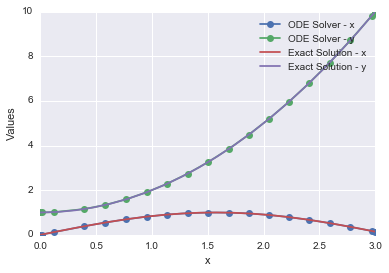

In [62]:
# reference solution using scipy package
sol = solve_ivp(f, [t.min(), t.max()], y0_list, method='Radau', rtol=1e-5)
plt.plot(sol.t, sol.y[0], marker='o', label='ODE Solver - x')
plt.plot(sol.t, sol.y[1], marker='o', label='ODE Solver - y')
plt.plot(t_, sol1, label = 'Exact Solution - x')
plt.plot(t_, sol2, label = 'Exact Solution - y')
plt.xlabel('x')
plt.ylabel('Values')
plt.legend()

# Neural Net Training

In [63]:
nn = NNSolver(f, t, y0_list, n_hidden=50)
nn

Neural ODE Solver 
Number of equations:       2 
Initial condition y0:      [0, 1] 
Numnber of hidden units:   50 
Number of training points: 20 

In [64]:
nn.reset_weights()
%time nn.train(maxiter=1000, iprint=100)

iteration: 0 loss:  2640.40073127
iteration: 100 loss:  2.83254710806e-05
iteration: 200 loss:  4.03722399713e-07
iteration: 300 loss:  6.80502144271e-08
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 309
         Function evaluations: 346
         Gradient evaluations: 346
CPU times: user 6.62 s, sys: 97.4 ms, total: 6.72 s
Wall time: 4.98 s


# Verifying training set

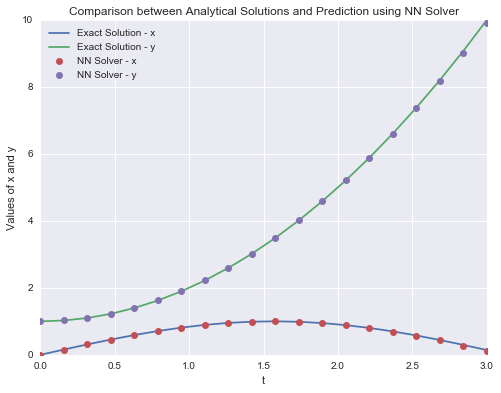

In [66]:
y_pred_list, dydt_pred_list = nn.predict()

plt.figure(figsize=(8, 6))
# exact soln
plt.plot(t_, sol1, label = 'Exact Solution - x')
plt.plot(t_, sol2, label = 'Exact Solution - y')

# nn soln
plt.plot(t, y_pred_list[0], 'o', label='NN Solver - x')
plt.plot(t, y_pred_list[1], 'o', label='NN Solver - y')

plt.legend(loc = 'best')
plt.ylabel('Values of x and y')
plt.xlabel('t')
plt.title("Comparison between Analytical Solutions and Prediction using NN Solver");

In [70]:
np.mean([sqrt(mean_squared_error(solActual[i], y_pred_list[i])) for i in range(2)])

0.017737017036048963

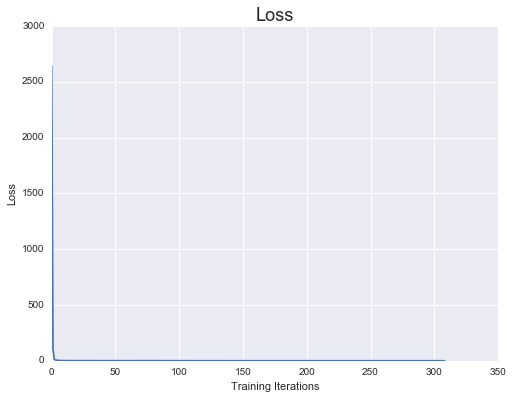

In [71]:
nn.plot_loss()

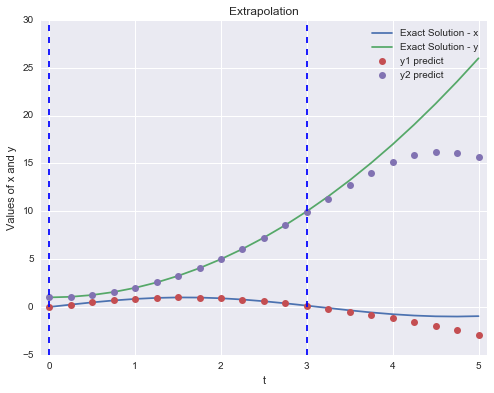

In [73]:
t_test = np.linspace(0, 5.0, 21).reshape(-1,1)
y_pred_list, dydt_pred_list = nn.predict(t = t_test)

t_ = np.linspace(0, 5.0, 21)
sol1_test = [np.sin(tt) for tt in t_]
sol2_test = [1 + (tt**2) for tt in t_]

plt.figure(figsize=(8, 6))
plt.plot(t_, sol1_test, label = 'Exact Solution - x')
plt.plot(t_, sol2_test, label = 'Exact Solution - y')

plt.plot(t_test, y_pred_list[0], 'o', label='y1 predict')
plt.plot(t_test, y_pred_list[1], 'o', label='y2 predict')
plt.axvline(x = 0, linestyle = '--')
plt.axvline(x = 3 , linestyle = '--')
plt.xlim((-0.1, 5.1))
plt.legend()
plt.title('Extrapolation')
plt.ylabel('Values of x and y')
plt.xlabel('t')

# Performance over 100 Fittings

In [74]:
res_arr = []
for _ in range(100):
    nn = NNSolver(f, t, y0_list, n_hidden=20)
    nn.reset_weights()
    nn.train(maxiter=500)
    y_pred_list, dydt_pred_list = nn.predict()
    res_arr.append(np.mean([sqrt(mean_squared_error(solActual[i], y_pred_list[i])) for i in range(2)]))

iteration: 0 loss:  125.369095669
iteration: 200 loss:  2.45643737029e-05
iteration: 400 loss:  7.27662307202e-07
         Current function value: 0.000000
         Iterations: 500
         Function evaluations: 553
         Gradient evaluations: 553
iteration: 0 loss:  29.7659781417
iteration: 200 loss:  3.98910848635e-06
iteration: 400 loss:  1.04625301651e-06
         Current function value: 0.000000
         Iterations: 500
         Function evaluations: 557
         Gradient evaluations: 557
iteration: 0 loss:  50.7514570724
iteration: 200 loss:  7.59181228607e-05
iteration: 400 loss:  1.40689823209e-06
         Current function value: 0.000000
         Iterations: 500
         Function evaluations: 564
         Gradient evaluations: 564
iteration: 0 loss:  1169.66660175
iteration: 200 loss:  8.5423723161e-06
iteration: 400 loss:  3.39814276308e-07
         Current function value: 0.000000
         Iterations: 500
         Function evaluations: 558
         Gradient evaluations: 5

(array([ 54.,  13.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,  31.]), array([  8.64441263e-04,   3.71819868e-01,   7.42775294e-01,
         1.11373072e+00,   1.48468615e+00,   1.85564157e+00,
         2.22659700e+00,   2.59755243e+00,   2.96850785e+00,
         3.33946328e+00,   3.71041871e+00]), <a list of 10 Patch objects>)


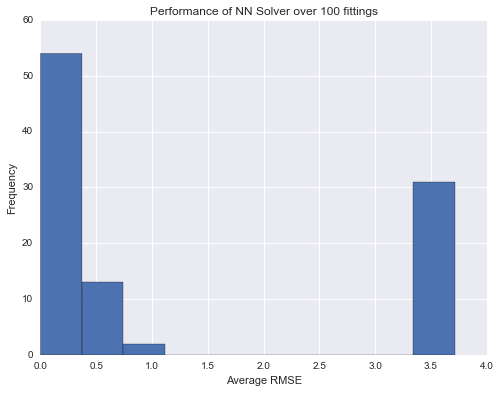

In [82]:
plt.figure(figsize= (8, 6))
figur = plt.hist(res_arr, bins=10)
plt.title('Performance of NN Solver over 100 fittings')
plt.xlabel('Average RMSE')
plt.ylabel('Frequency')
print (figur)